# Fake News Detection System

In [2]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
import string
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import os
print(os.getcwd())

c:\Users\Admin\Downloads\Task3\Fake_news_detection


In [12]:
import os
print("Current working directory:", os.getcwd())
print("Files in current directory:", os.listdir())
print("Files in 'Fake_news_detection':", os.listdir('Fake_news_detection') if os.path.exists('Fake_news_detection') else "Folder not found")

Current working directory: c:\Users\Admin\Downloads\Task3\Fake_news_detection
Files in current directory: ['3_Fake_News_Detection_System.ipynb', 'Fake.csv', 'True.csv']
Files in 'Fake_news_detection': Folder not found


In [13]:
# 2. Load and Explore Dataset
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

print('Fake news shape:', fake_df.shape)
print('True news shape:', true_df.shape)
fake_df.head()

Fake news shape: (23481, 4)
True news shape: (21417, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [14]:
# 3. Prepare Data for Classification
fake_df['label'] = 'FAKE'
true_df['label'] = 'REAL'
df = pd.concat([fake_df, true_df], ignore_index=True)
print('Combined dataset shape:', df.shape)
df[['title', 'text', 'label']].head()

Combined dataset shape: (44898, 5)


,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,FAKE
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,FAKE
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",FAKE
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",FAKE
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,FAKE


In [15]:
# 4. Text Preprocessing
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = str(text).lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')
df['clean_text'] = df['clean_text'].apply(clean_text)
df[['clean_text', 'label']].head()

,clean_text,label
0,donald trump sends embarrassing new year’s eve...,FAKE
1,drunk bragging trump staffer started russian c...,FAKE
2,sheriff david clarke becomes internet joke thr...,FAKE
3,trump obsessed even obama’s name coded website...,FAKE
4,pope francis called donald trump christmas spe...,FAKE


In [16]:
# 5. Vectorize Text and Train-Test Split
X = df['clean_text']
y = df['label']

vectorizer = TfidfVectorizer(max_features=10000)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.988641425389755
Confusion Matrix:
 [[4624   72]
 [  30 4254]]
Classification Report:
               precision    recall  f1-score   support

        FAKE       0.99      0.98      0.99      4696
        REAL       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [17]:
# 6. Show Top Important Words for Each Class
import numpy as np

def show_top_words(model, vectorizer, n=15):
    feature_names = np.array(vectorizer.get_feature_names_out())
    if hasattr(model, 'coef_'):
        coefs = model.coef_[0]
        top_positive = np.argsort(coefs)[-n:]
        top_negative = np.argsort(coefs)[:n]
        print("Top words for REAL news:", feature_names[top_positive][::-1])
        print("Top words for FAKE news:", feature_names[top_negative])
    elif hasattr(model, 'feature_log_prob_'):
        for i, class_label in enumerate(model.classes_):
            top = np.argsort(model.feature_log_prob_[i])[-n:]
            print(f"Top words for class '{class_label}':", feature_names[top][::-1])
            print()

show_top_words(lr, vectorizer)

Top words for REAL news: ['reuters' 'said' 'we' 'it' 'washington' 'the' 'wednesday' 'tuesday' 'us'
 'thursday' 'republican' 'friday' 'monday' 'minister' 'nov']
Top words for FAKE news: ['video' 'via' 'hillary' 'gop' 'image' 'obama' 'america' 'even' 'like'
 'mr' 'american' 'breaking' 'watch' 'wire' 'images']


In [18]:
# 7. Compare with Naive Bayes (Optional, now active)
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print('Naive Bayes Accuracy:', accuracy_score(y_test, y_pred_nb))
print('Naive Bayes Confusion Matrix:\n', confusion_matrix(y_test, y_pred_nb))
print('Naive Bayes Classification Report:\n', classification_report(y_test, y_pred_nb))
show_top_words(nb, vectorizer)

Naive Bayes Accuracy: 0.9404231625835189
Naive Bayes Confusion Matrix:
 [[4416  280]
 [ 255 4029]]
Naive Bayes Classification Report:
               precision    recall  f1-score   support

        FAKE       0.95      0.94      0.94      4696
        REAL       0.94      0.94      0.94      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980

Top words for class 'FAKE': ['trump' 'video' 'clinton' 'obama' 'hillary' 'people' 'president' 'one'
 'said' 'like' 'donald' 'would' 'us' 'news' 'white']

Top words for class 'REAL': ['said' 'trump' 'us' 'reuters' 'would' 'president' 'house' 'state'
 'government' 'republican' 'washington' 'united' 'states' 'north' 'new']



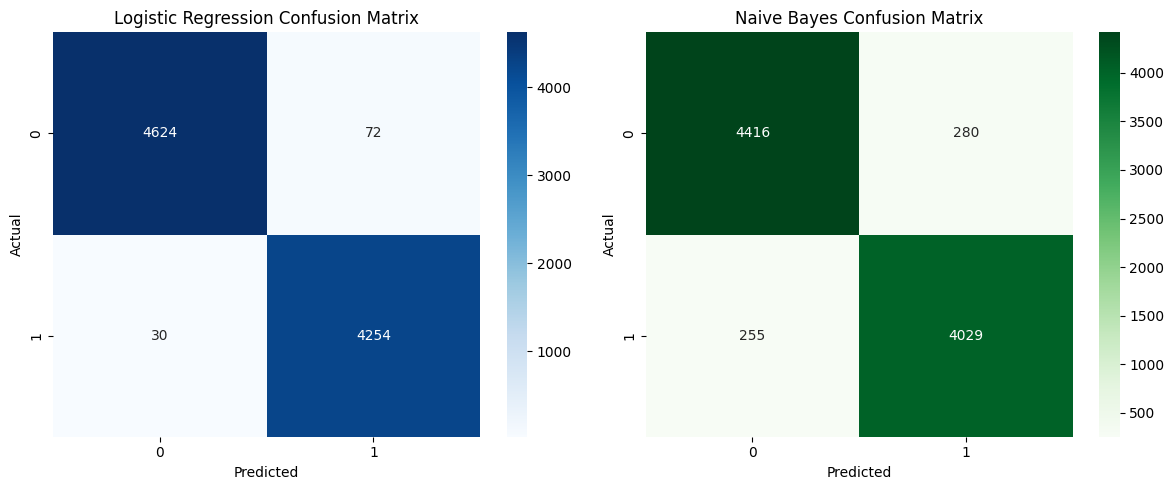

In [19]:
# 8. Visualize Confusion Matrices for Both Models
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Naive Bayes Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Naive Bayes Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()